In [1]:
import MDAnalysis as mda
import numpy as np
import os
import glob

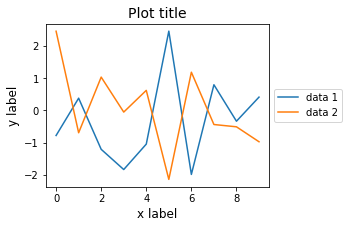

In [2]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
params = {'axes.labelsize': 12,
          'axes.titlesize': 14,
          'figure.titlesize': 16,
          'legend.fontsize': 10,
          'legend.title_fontsize': 12}
plt.rcParams.update(params)
# plt.rcParams.update(plt.rcParamsDefault)

fig, ax = plt.subplots(figsize=[4, 3])
ax.plot(np.random.randn(10), label='data 1')
ax.plot(np.random.randn(10), label='data 2')
ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.set_title('Plot title')
# ax.legend()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [3]:
# Paths
project_path = os.path.abspath('..')
data_path = os.path.join(project_path, 'data')
print(f"data path exists: {os.path.exists(data_path)}")

data path exists: True


In [4]:
eq_dirpath = os.path.join(data_path, 'Adk_eq_MDAna')
psf_path = os.path.join(eq_dirpath, 'adk4AKE.psf')
dcd_path = os.path.join(eq_dirpath, '1ake_007-nowater-core-dt240ps.dcd')
u_eq = mda.Universe(psf_path, dcd_path)
u_eq.transfer_to_memory()

In [5]:
DIMS_dirpath = os.path.join(data_path, 'Adk_DIMS_MDAna')
psf_path = os.path.join(DIMS_dirpath, 'topologies', 'adk4ake.psf')
dcd_dirpath = os.path.join(DIMS_dirpath, 'trajectories')
dcd_list = glob.glob(os.path.join(dcd_dirpath, '*.dcd'))
# dcd_list = dcd_list[0:5]
u_DIMS_list = []
for dcd_path in dcd_list:
    u_DIMS = mda.Universe(psf_path, dcd_path)
    u_DIMS.transfer_to_memory()
    u_DIMS_list.append(u_DIMS)

In [6]:
dcd_list

['/mnt/sda/MDTutorials/data/DIMS_MDAna/trajectories/dims0002_fit-core.dcd',
 '/mnt/sda/MDTutorials/data/DIMS_MDAna/trajectories/dims0006_fit-core.dcd',
 '/mnt/sda/MDTutorials/data/DIMS_MDAna/trajectories/dims0010_fit-core.dcd',
 '/mnt/sda/MDTutorials/data/DIMS_MDAna/trajectories/dims0008_fit-core.dcd',
 '/mnt/sda/MDTutorials/data/DIMS_MDAna/trajectories/dims0003_fit-core.dcd',
 '/mnt/sda/MDTutorials/data/DIMS_MDAna/trajectories/dims0001_fit-core.dcd',
 '/mnt/sda/MDTutorials/data/DIMS_MDAna/trajectories/dims0004_fit-core.dcd',
 '/mnt/sda/MDTutorials/data/DIMS_MDAna/trajectories/dims0007_fit-core.dcd',
 '/mnt/sda/MDTutorials/data/DIMS_MDAna/trajectories/dims0005_fit-core.dcd',
 '/mnt/sda/MDTutorials/data/DIMS_MDAna/trajectories/dims0009_fit-core.dcd']

In [7]:
# https://www.mdanalysis.org/MDAnalysisTutorial/trajectories.html
def theta(A, B, C):
    """Calculate the angle between BA and BC for AtomGroups A, B, C"""
    B_center = B.centroid()
    BA = A.centroid() - B_center
    BC = C.centroid() - B_center
    theta = np.arccos(np.dot(BA, BC)/(np.linalg.norm(BA)*np.linalg.norm(BC)))
    return np.rad2deg(theta)

def get_NMP_ABC(u):
    NMP_C = u.select_atoms("resid 115-125 and (backbone or name CB)")
    NMP_B = u.select_atoms("resid 90-100 and (backbone or name CB)")
    NMP_A = u.select_atoms("resid 35-55 and (backbone or name CB)")
    return NMP_A, NMP_B, NMP_C

def get_LID_ABC(u):    
    LID_C = u.select_atoms("resid 179-185 and (backbone or name CB)")
    LID_B = u.select_atoms("resid 115-125 and (backbone or name CB)")
    LID_A = u.select_atoms("resid 125-153 and (backbone or name CB)")
    return LID_A, LID_B, LID_C

In [8]:
def calc_traj_data(u):
    NMP = get_NMP_ABC(u)
    LID = get_LID_ABC(u)
    data = np.array([(u.trajectory.time, 
                      theta(*NMP), 
                      theta(*LID)) \
                      for ts in u.trajectory])
    time, NMP, LID = data.T
    d = dict(time=time, NMP=NMP, LID=LID)
    return d

def unwrap_NMP_LID(d):
    time = d['time']
    NMP = d['NMP']
    LID = d['LID']
    return time, NMP, LID

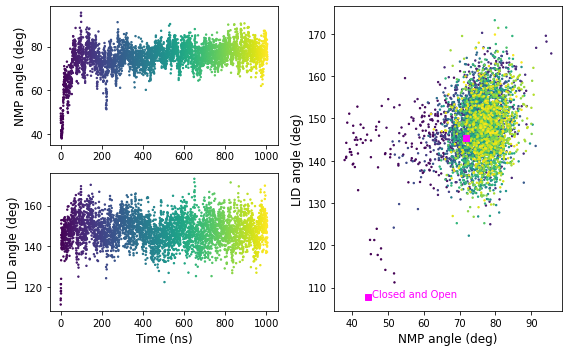

In [9]:
d_eq = calc_traj_data(u_eq)
time, NMP, LID = unwrap_NMP_LID(d_eq)
fig = plt.figure(figsize=[8, 5])
gs = GridSpec(2, 2)
ax = fig.add_subplot(gs[0, 0])
ax.scatter(time / 10**3, NMP, s=2, c=time, label='eq')
ax.set_ylabel('NMP angle (deg)')

ax = fig.add_subplot(gs[1, 0])
ax.scatter(time / 10**3, LID, s=2, c=time, label='eq')
ax.set_ylabel('LID angle (deg)')
ax.set_xlabel('Time (ns)')

ax = fig.add_subplot(gs[:, 1])
ax.scatter(NMP, LID, s=2, c=time)
ax.set_xlabel('NMP angle (deg)')
ax.set_ylabel('LID angle (deg)')
#
ax.plot(71.75378029, 145.41171436, 's', color='magenta')
ax.plot(44.4732217,  107.77880175, 's', color='magenta')
ax.annotate('Closed and Open', (44.4732217 + 1,  107.7788017), color='magenta')
plt.tight_layout()
plt.show()

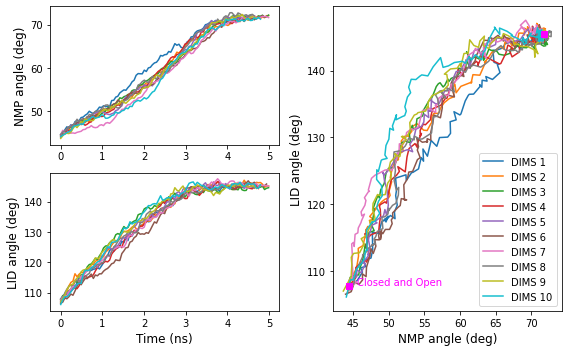

In [10]:
fig = plt.figure(figsize=[8, 5])
gs = GridSpec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:, 1])

for i, u_DIMS in enumerate(u_DIMS_list):
    d_DIMS = calc_traj_data(u_DIMS)
    time, NMP, LID = unwrap_NMP_LID(d_DIMS)

    ax = ax1
    ax.plot(time / 10**3, NMP, '-')
    ax.set_ylabel('NMP angle (deg)')

    ax = ax2
    ax.plot(time / 10**3, LID, '-')
    ax.set_ylabel('LID angle (deg)')
    ax.set_xlabel('Time (ns)')

    ax = ax3
    ax.plot(NMP, LID, '-', label=f'DIMS {i+1}')
    ax.set_xlabel('NMP angle (deg)')
    ax.set_ylabel('LID angle (deg)')
    ax.legend()
# 
ax.plot(71.75378029, 145.41171436, 's', color='magenta')
ax.plot(44.4732217,  107.77880175, 's', color='magenta')
ax.annotate('Closed and Open', (44.4732217 + 1,  107.7788017), color='magenta')
# 
plt.tight_layout()
plt.show()

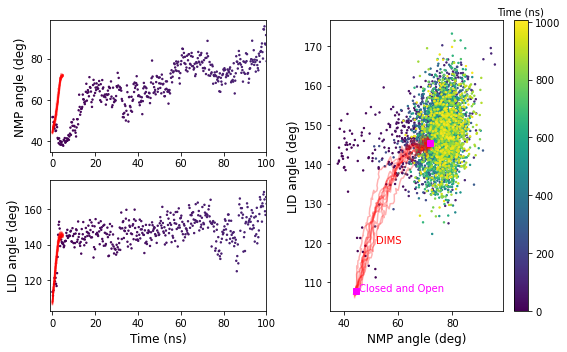

In [11]:
d_eq = calc_traj_data(u_eq)
time_eq, NMP_eq, LID_eq = unwrap_NMP_LID(d_eq)
alpha = 0.3
fig = plt.figure(figsize=[8, 5])
gs = GridSpec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[:, 1])

ax1.scatter(time_eq / 10**3, NMP_eq, s=2, c=time_eq / 10**3)
ax2.scatter(time_eq / 10**3, LID_eq, s=2, c=time_eq / 10**3)
im = ax3.scatter(NMP_eq, LID_eq, s=2, c=time_eq  / 10**3)
cbar = plt.colorbar(im)
cbar.ax.set_title('Time (ns)', fontsize=10)

for i, u_DIMS in enumerate(u_DIMS_list):
    d_DIMS = calc_traj_data(u_DIMS)
    time, NMP, LID = unwrap_NMP_LID(d_DIMS)

    ax = ax1
    ax.plot(time / 10**3, NMP, '-', color='r', alpha=alpha)
    ax.set_ylabel('NMP angle (deg)')

    ax = ax2
    ax.plot(time / 10**3, LID, '-', color='r', alpha=alpha)
    ax.set_ylabel('LID angle (deg)')
    ax.set_xlabel('Time (ns)')

    ax = ax3
    ax.plot(NMP, LID, '-', color='r', alpha=alpha)
    ax.set_xlabel('NMP angle (deg)')
    ax.set_ylabel('LID angle (deg)')
    # ax.legend()
# 
for ax in [ax1, ax2]:
    ax.set_xlim([-1, 100])
# 
ax3.plot(71.75378029, 145.41171436, 's', color='magenta')
ax3.plot(44.4732217,  107.77880175, 's', color='magenta')
ax3.annotate('Closed and Open', (44.4732217 + 1,  107.7788017), color='magenta')
ax3.annotate('DIMS', (52, 120), color='r')
# 
plt.tight_layout()
plt.show()

# Hbonds (messy)

In [12]:
import pandas as pd

In [13]:
# u = u_DIMS_list[0]
u = u_eq

In [39]:
# https://docs.mdanalysis.org/dev/documentation_pages/analysis/hydrogenbonds.html
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA
hbonds = HBA(universe=u)
hbonds.hydrogens_sel = hbonds.guess_hydrogens("protein")
hbonds.acceptors_sel = hbonds.guess_acceptors("protein")
last_time = 200*10**3  # ps
last_frame = np.argwhere(time_eq <= last_time).flatten()[-1]
hbonds.run(step=10, stop=last_frame)

In [40]:
# Dataframe of time, donor, H, acceptor, distance, angle
# These are indexed by number for each time and bond
results = hbonds.hbonds
columns = ['time', 'D', 'H', 'A', 'dist', 'ang']
df = pd.DataFrame(results, columns=columns)

In [41]:
df.head()

,time,D,H,A,dist,ang
0,0.0,19.0,20.0,1578.0,2.641195,165.609908
1,0.0,62.0,63.0,1601.0,2.882901,156.815656
2,0.0,81.0,82.0,1275.0,2.595836,168.135402
3,0.0,100.0,101.0,1636.0,2.826750,160.859016
4,0.0,190.0,192.0,1285.0,2.729635,166.223815


In [42]:
df.tail()

,time,D,H,A,dist,ang
6297,830.0,2976.0,2977.0,1580.0,2.842983,150.899510
6298,830.0,2992.0,2994.0,3335.0,2.814766,150.947210
6299,830.0,3011.0,3012.0,1649.0,2.580698,170.698055
6300,830.0,3079.0,3080.0,1683.0,2.803285,171.867629
6301,830.0,3086.0,3087.0,3076.0,2.900575,156.197920


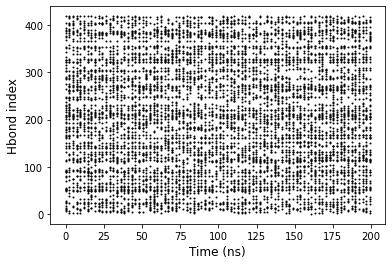

In [43]:
DA_pairs = list(zip(df['D'].astype('int'), 
                    df['A'].astype('int')))
DA_pairs = list(set(DA_pairs))
hbonds_dict = dict.fromkeys(DA_pairs)
for key in hbonds_dict.keys():
    # NOTE: do not try initializing with value starting
    # from dict.fromkeys(index, values). Even with .copy()
    hbonds_dict[key] = dict(D=key[0], A=key[1], 
                            time=[], ang=[], dist=[])
#
# Fill dictionary from df that is indexed by time-bond
cols = ['time', 'ang', 'dist']
for i, row in df.iterrows():
    key = (row['D'], row['A'])
    for col in cols:
        hbonds_dict[key][col].append(row[col])
#
hbonds_df = pd.DataFrame.from_dict(hbonds_dict, orient='index')
fig, ax = plt.subplots()
for i, (index, row) in enumerate(hbonds_df.iterrows()):
    # c = colors[np.array(row['time']).astype('int'), :]
    ax.scatter(np.array(row['time'])*u.trajectory.dt/10**3, 
               i*np.ones(len(row['time'])), 
               s=1, c='k')
#
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Hbond index')
plt.show()

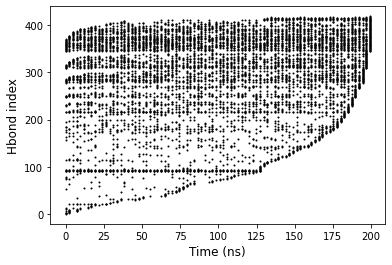

In [44]:
hbonds_df['avg_time'] = hbonds_df['time'].apply(np.mean)
hbonds_df['last_time'] = hbonds_df['time'].apply(np.max)
hbonds_df['first_time'] = hbonds_df['time'].apply(np.min)
hbonds_df.sort_values(by=['last_time', 'first_time'], inplace=True)

fig, ax = plt.subplots()
for i, (index, row) in enumerate(hbonds_df.iterrows()):
    # c = colors[np.array(row['time']).astype('int'), :]
    ax.scatter(np.array(row['time'])*u.trajectory.dt/10**3, 
               i*np.ones(len(row['time'])), 
               s=1, c='k')
#
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Hbond index')
plt.show()

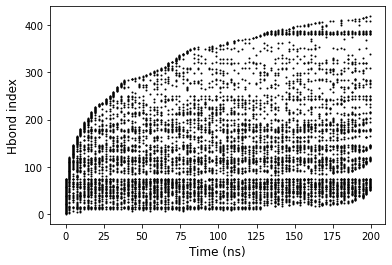

In [45]:
hbonds_df.sort_values(by=['first_time', 'last_time'], inplace=True)
fig, ax = plt.subplots()
for i, (index, row) in enumerate(hbonds_df.iterrows()):
    # c = colors[np.array(row['time']).astype('int'), :]
    ax.scatter(np.array(row['time'])*u.trajectory.dt/10**3, 
               i*np.ones(len(row['time'])), 
               s=1, c='k')
#
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Hbond index')
plt.show()

In [46]:
# Looks like this broke in the update... 
# fig, ax = plt.subplots(figsize=[8, 2])
# ax.plot(hbonds.times / 10**3, hbonds.count_by_time())
# ax.set_xlabel('Time (ns)')
# ax.set_ylabel('# Hbonds')
# plt.show()

# hbonds.count_by_type()

# hbonds.count_by_ids()

In [47]:
def atomid2resid(atomid):
    return u.atoms[atomid].resid

In [48]:
# https://userguide.mdanalysis.org/stable/topology_system.html
hbonds_df['Dres'] = hbonds_df['D'].apply(atomid2resid)
hbonds_df['Ares'] = hbonds_df['A'].apply(atomid2resid)
hbonds_df

,,D,A,time,ang,dist,avg_time,last_time,first_time,Dres,Ares
847,2657,847,2657,[0.0],[150.16440894795815],[2.8079762275365114],0.000000,0.0,0.0,57,170
2476,2439,2476,2439,[0.0],[160.19256565966154],[2.795226631491039],0.000000,0.0,0.0,160,157
2739,1352,2739,1352,[0.0],[166.3588543047919],[2.722658379097818],0.000000,0.0,0.0,175,88
2603,2460,2603,2460,"[0.0, 10.0]","[160.22724888001474, 163.7204431471284]","[2.676038241368609, 2.634411057526969]",5.000000,10.0,0.0,167,159
2407,2448,2407,2448,"[0.0, 10.0, 30.0]","[154.80007566963684, 159.5433268562844, 177.55...","[2.9345853413483542, 2.730393774702177, 2.7776...",13.333333,30.0,0.0,156,158
...,...,...,...,...,...,...,...,...,...,...,...
902,910,902,910,[810.0],[155.83525074197885],[2.789828295373299],810.000000,810.0,810.0,61,61
2581,2507,2581,2507,[810.0],[175.2228239809118],[2.8021886147678448],810.000000,810.0,810.0,166,162
1741,1713,1741,1713,[820.0],[153.5650302330141],[2.9765055831017735],820.000000,820.0,820.0,115,112
2771,2746,2771,2746,[820.0],[150.388154962351],[2.7847533812729846],820.000000,820.0,820.0,178,175


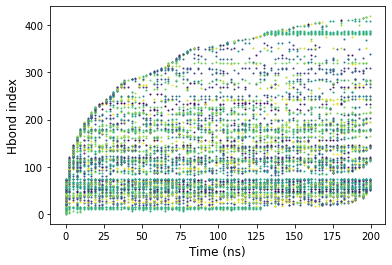

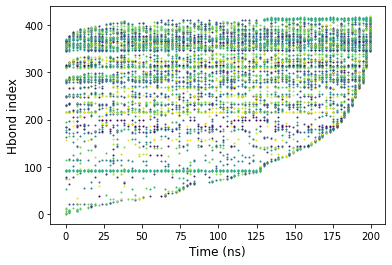

In [49]:
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=np.min(hbonds_df['Dres']), 
                            vmax=np.max(hbonds_df['Dres']))
cmap = mpl.cm.get_cmap('viridis')

hbonds_df.sort_values(by=['first_time', 'last_time'], inplace=True)
fig, ax = plt.subplots()
for i, (index, row) in enumerate(hbonds_df.iterrows()):
    # c = colors[np.array(row['time']).astype('int'), :]
    ax.scatter(np.array(row['time'])*u.trajectory.dt/10**3, 
               i*np.ones(len(row['time'])), 
               s=1, color=cmap(norm(row['Dres'])))
#
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Hbond index')
plt.show()

hbonds_df.sort_values(by=['last_time', 'first_time'], inplace=True)
fig, ax = plt.subplots()
for i, (index, row) in enumerate(hbonds_df.iterrows()):
    # c = colors[np.array(row['time']).astype('int'), :]
    ax.scatter(np.array(row['time'])*u.trajectory.dt/10**3, 
               i*np.ones(len(row['time'])), 
               s=1, color=cmap(norm(row['Dres'])))
#
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Hbond index')
plt.show()

# Salt bridges

## Version 1

average contacts = 0.3390688224075209


<ipython-input-63-458682671bda>:24: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


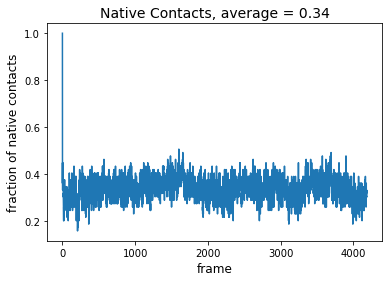

In [63]:
# https://docs.mdanalysis.org/1.0.0/documentation_pages/analysis/contacts.html
from MDAnalysis.analysis import contacts

sel_basic = "(resname ARG LYS) and (name NH* NZ)"
sel_acidic = "(resname ASP GLU) and (name OE* OD*)"
# reference groups (first frame of the trajectory, but you could also use a
# separate PDB, eg crystal structure)
acidic = u.select_atoms(sel_acidic)
basic = u.select_atoms(sel_basic)
# set up analysis of native contacts ("salt bridges"); salt bridges have a
# distance <6 A
ca = contacts.Contacts(u, select=(sel_acidic, sel_basic),
                        refgroup=(acidic, basic), radius=6.0)
# iterate through trajectory and perform analysis of "native contacts" Q
ca.run()
# print number of averave contacts
average_contacts = np.mean(ca.timeseries[:, 1])
print('average contacts = {}'.format(average_contacts))
# plot time series q(t)
fig, ax = plt.subplots()
ax.plot(ca.timeseries[:, 0], ca.timeseries[:, 1])
ax.set(xlabel='frame', ylabel='fraction of native contacts',
       title='Native Contacts, average = {:.2f}'.format(average_contacts))
fig.show()


## Version 2

In [66]:
sel_basic = "(resname ARG LYS) and (name NH* NZ)"
sel_acidic = "(resname ASP GLU) and (name OE* OD*)"
acidic = u.select_atoms(sel_acidic)
basic = u.select_atoms(sel_basic)

def fraction_contacts_between(r, r0, radius=3.4, min_radius=2.5):
    is_in_contact = (r < radius) & (r > min_radius)  # array of bools
    fraction = is_in_contact.sum()/r.size
    return fraction

ca = contacts.Contacts(u,
                       select=(sel_acidic, sel_basic),
                       refgroup=(acidic, basic),
                       method=fraction_contacts_between,
                       radius=5.0,
                       kwargs={'radius': 5.0,
                               'min_radius': 2.4}).run()
ca.run()

In [75]:
ca_df = pd.DataFrame(ca.timeseries,
                    columns=['Frame',
                             'Contacts from first frame'])
ca_df.head()
ca_df.tail()

,Frame,Contacts from first frame
4182,4182.0,0.387755
4183,4183.0,0.408163
4184,4184.0,0.448980
4185,4185.0,0.448980
4186,4186.0,0.428571


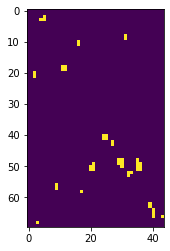

In [81]:
plt.imshow(ca.initial_contacts[0])
plt.show()

In [84]:
ca.grA.resids

array([ 22,  22,  33,  33,  44,  44,  51,  51,  54,  54,  61,  61,  62,
        62,  70,  70,  75,  75,  76,  76,  84,  84,  94,  94,  98,  98,
       104, 104, 108, 108, 110, 110, 113, 113, 114, 114, 118, 118, 143,
       143, 146, 146, 147, 147, 151, 151, 152, 152, 158, 158, 159, 159,
       161, 161, 162, 162, 170, 170, 185, 185, 187, 187, 197, 197, 204,
       204, 208, 208, 210, 210])

In [85]:
ca.grB.resids

array([  2,   2,  13,  23,  36,  36,  40,  47,  50,  57,  69,  71,  71,
        78,  78,  88,  88,  97, 119, 119, 123, 123, 124, 124, 131, 131,
       136, 141, 145, 156, 156, 157, 165, 165, 166, 167, 167, 184, 192,
       195, 200, 206, 206, 211])